<a href="https://colab.research.google.com/github/arkeodev/demistify_deep_learning_applications/blob/main/Demistifying_YOLO_Object_Detection_From_Theory_to_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demistifying YOLO Object Detection for myself: From Theory to Implementation

Object detection is a crucial task in computer vision that involves identifying and localizing objects within an image. Among the numerous approaches to object detection, YOLO (You Only Look Once) has emerged as one of the most effective and efficient methods. In this blog post, we delve into the fundamentals of YOLO object detection, its implementation, and the implementation in PyTorch, with a focus on practical application using the COCO dataset.

## Imports

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import trange, tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Device Check

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cpu device


## Understanding YOLO Object Detection

Understanding the core concepts behind YOLO (You Only Look Once) object detection is essential for mastering how it revolutionizes object detection tasks, particularly in terms of speed and accuracy. Let's delve deeper into the intricacies of YOLO, the concept of bounding boxes, and the crucial metric of Intersection Over Union (IoU).

When try to explain the details, I used the wonderful Medium entry of Jonathan Hui: [Real-time Object Detection with YOLO, YOLOv2 and now YOLOv3](https://jonathan-hui.medium.com/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)

YOLO fundamentally changes the object detection landscape by treating the task as a single regression problem from image pixels to bounding box coordinates and class probabilities. This approach contrasts sharply with traditional methods, which typically involve a two-step process: first proposing candidate regions (region proposals) and then classifying each region into various categories.



![Objects Detected by YOLO](https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/images/yolo_demo_image.png#:~:text=Raw%20file%20content-,Download,-%E2%8C%98)

#### How YOLO Works:

1. **Single Convolutional Network:** YOLO uses a single convolutional network to predict multiple bounding boxes and class probabilities for those boxes simultaneously. This end-to-end training and prediction model dramatically increases the speed of detection.

2. **Spatial Division of Images:** The image is divided into an $(S×S$) grid, and for each grid cell, YOLO predicts $(B$) bounding boxes and confidence scores for those boxes. Confidence reflects the accuracy of the bounding box and the probability that the box contains a specific object.

3. **Class Probabilities:** Alongside bounding box predictions, YOLO also predicts class probabilities for each grid cell, irrespective of the number of boxes $(B$).

#### Advantages:

**Global Context:** Unlike region proposal-based methods, YOLO sees the entire image during training and test time, allowing it to implicitly encode contextual information about classes.

**Speed:** By simplifying the detection into a single network forward pass, YOLO achieves remarkable speed, making it suitable for real-time applications.

**Predictions** (object locations and classes) are made from one single network. Can be trained end-to-end to improve accuracy.

**YOLO is more generalized.** It outperforms other methods when generalizing from natural images to other domains like artwork.

**YOLO detects one object per grid cell.** It enforces spatial diversity in making predictions.

## Dataset and Preprocessing

### Understanding the COCO Format

For our implementation, we utilize the COCO dataset. The COCO (Common Objects in Context) dataset is a large-scale object detection, segmentation, and captioning dataset. The COCO format is a specific way that the dataset annotates images, making it a standard for various computer vision tasks. This format is particularly designed to facilitate the training and evaluation of algorithms on the dataset.

The COCO dataset includes over 200,000 images with more than 500,000 object instances across 80 categories, offering a diverse and substantial volume of data for robust model training.

The COCO dataset format organizes annotation information in a structured JSON file, which includes:

**Images:** A list of images with their file names, image IDs, URLs, height, and width.

**Annotations:** Contains details about each object instance in the images, including:
* Object bounding box coordinates (in the format `[x, y, width, height]`).
* The category ID of the object.
* An annotation ID unique to each object instance.
* Segmentation information for instance segmentation tasks.

**Categories:** Lists all object categories in the dataset, each with a unique category ID and name.

This structured format allows for easy parsing and utilization in training object detection models, supporting tasks like bounding box object detection and instance segmentation.

The COCO dataset can be accessed and downloaded from the [COCO Dataset Official Website](https://cocodataset.org/#home). Here, you can find links to download the images and annotations for different years and tasks, along with additional resources and tools for working with the dataset.

### Download the Data

First, let's create the directory structure where the dataset will be stored.

In [1]:
!mkdir -p coco/images/train2017 coco/images/val2017 coco/annotations

Next, use the following commands to download the training and validation images and annotations for the COCO 2017 dataset. Note that these files are quite large, so the download may take some time depending on your internet connection.

In [2]:
! wget http://images.cocodataset.org/zips/train2017.zip -P coco/images
! wget http://images.cocodataset.org/zips/val2017.zip -P coco/images
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P coco/annotations

--2024-03-05 16:20:34--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.203.249, 52.217.231.97, 52.216.152.132, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.203.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco/images/train2017.zip’

train2017.zip       100%[===================>]  18.01G  46.3MB/s    in 6m 58s  

2024-03-05 16:27:32 (44.1 MB/s) - ‘coco/images/train2017.zip’ saved [19336861798/19336861798]

--2024-03-05 16:27:32--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.32.172, 52.217.233.209, 52.217.118.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.32.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco/images/val2017.zip’

val201

After downloading, unzip the files to their respective directories.

In [3]:
! unzip -q coco/images/train2017.zip -d coco/images
! unzip -q coco/images/val2017.zip -d coco/images
! unzip -q coco/annotations/annotations_trainval2017.zip -d coco/annotations

After executing these commands, your folder structure should look like this:

![COCO folder structure](https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/images/coco_folder_structure.png#:~:text=Copy-,permalink,-%E2%8C%98)

Optionally, after unzipping, you can remove the downloaded .zip files to save space.

In [4]:
! rm coco/images/train2017.zip
! rm coco/images/val2017.zip
! rm coco/annotations/annotations_trainval2017.zip

### Image Sample

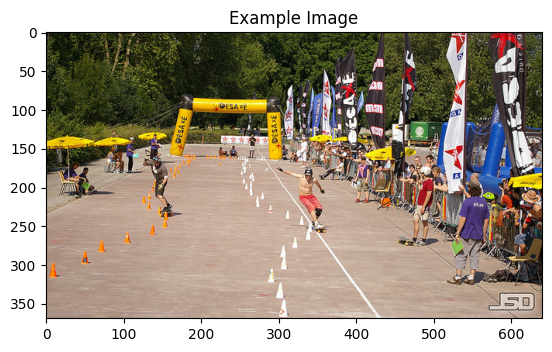

In [117]:
import numpy as np
from PIL import Image
from pathlib import Path

current_dir = Path.cwd()

# Traverse the folder and get the path of the first image file under "coco/images/train2017"
image_dir = current_dir / "coco/images/train2017"
image_files = list(image_dir.glob('*.jpg'))  # Assuming the images are in jpg format

if image_files:
    first_image_path = image_files[0]
else:
    first_image_path = "No image found in the specified path."

# Example of loading an image and converting it
image = Image.open(first_image_path)
image_np = np.array(image)  # Convert PIL image to numpy array

# Display the image using matplotlib
plt.imshow(image_np)
plt.title('Example Image')
plt.show()


### Annotation Format

When focusing on object detection, two key pieces of information in the COCO annotations are crucial: category IDs and bounding box coordinates.

```
annotation{
  "id": int,
  "image_id": int,
  "category_id": int,
  "segmentation": RLE or [polygon],
  "area": float,
  "bbox": [x,y,width,height],
  "iscrowd": 0 or 1,
}

categories[{
  "id": int,
  "name": str,
  "supercategory": str,
}]
```

Annotation Structure
COCO annotations for object detection are typically structured in JSON format, containing several fields, but the most relevant ones for object detection include:

* image_id: A unique identifier for each image in the dataset.
* category_id: Specifies the class of the object. Each category_id corresponds to a specific class (e.g., person, bicycle, car) defined in the COCO dataset's class labels.
* bbox: The bounding box annotation for an object specified as `[x_min, y_min, width, height]`. These coordinates outline the rectangular region enclosing an object within the image.
The `x_min` and `y_min` represent the top-left corner of the rectangle, while `width` and `height` describe the rectangle's dimensions.
* area: The area of the bounding box. While not directly used for basic object detection tasks, it can be useful for segmentation or filtering annotations based on object size.
* iscrowd: A flag indicating if the annotation represents a single object `(iscrowd = 0)` or a group of objects `(iscrowd = 1)`. This is particularly relevant for segmentation tasks.

### Custom Dataset Class Processing


In the context of using the COCO dataset for training an object detection model with a selected subset of classes, like in the provided CustomCocoDetection class, the annotations are processed as follows:

**Filtering Annotations:**

Not all classes in the COCO dataset may be relevant to every object detection task. Therefore, the custom dataset class filters the annotations to include only those objects whose category_id matches one of the selected class IDs. This is accomplished using the coco_to_voc mapping, which translates COCO class IDs to a new set of class IDs corresponding to the subset of interest.

&nbsp;

**Remapping Class IDs:**

The COCO dataset includes a wide array of classes, but a specific project might only be interested in a subset of these. The coco_to_voc mapping is used to remap the original COCO category_ids to a new set of IDs that reflect the reduced class selection. This step simplifies the model's output space and aligns with the specific classes targeted by the project.

In [18]:
import json
from pathlib import Path

# The mapping from COCO class IDs to custom class IDs
coco_to_voc = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4,
    6: 5, 7: 6, 8: 7, 9: 8, 10: 9,
    11: 10, 13: 11, 14: 12, 15: 13, 16: 14,
    17: 15, 18: 16, 19: 17, 20: 18, 21: 19
}

# Path to the COCO annotations file
current_dir = Path.cwd()
annotations_file = current_dir / 'coco/annotations/annotations/instances_val2017.json'

with open(annotations_file, 'r') as f:
    data = json.load(f)

# Selected COCO class IDs based on the `coco_to_voc` mapping
selected_class_ids = coco_to_voc.keys()

# Extract the category information from the annotations
categories = data['categories']

# Create a dictionary mapping class IDs to class names
id_to_name = {category['id']: category['name'] for category in categories}

# Print the names of the selected classes
print("Selected Class Names:")
for class_id in selected_class_ids:
    class_name = id_to_name.get(class_id, 'Unknown Class ID')
    print(f"ID: {class_id}, Name: {class_name}")


Selected Class Names:
ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15, Name: bench
ID: 16, Name: bird
ID: 17, Name: cat
ID: 18, Name: dog
ID: 19, Name: horse
ID: 20, Name: sheep
ID: 21, Name: cow


### Grid Cell

YOLO divides the input image into an SxS grid. Each grid cell predicts only one object. For example, the yellow grid cell below tries to predict the "person" object whose center (the blue dot) falls inside the grid cell.

For each grid cell,

* it predicts B boundary boxes and each box has one box confidence score,
* it detects one object only regardless of the number of boxes B,
* it predicts C conditional class probabilities (one per class for the likeliness of the object class).

To evaluate the images, YOLO uses 7×7 grids (S×S), 2 boundary boxes (B) and 20 classes (C).

![](https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/images/grid_cell.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Adjusting Bounding Box Format

Bounding boxes are pivotal in object detection, serving as the basic element for localizing objects within an image. A bounding box is defined by four parameters: the $(x$) and $(y$) coordinates of the upper-left corner, and the width $(w$) and height $(h$) of the rectangle. These parameters enable the precise localization and identification of objects in an image, from a simple person to complex scenes with multiple interacting objects.

**Challenges with Bounding Boxes:**

* Accuracy: Precisely predicting the size and location of bounding boxes is challenging, especially with objects of varying scales and orientations.

* Overlap: In densely populated scenes, handling overlapping boxes requires careful consideration, often addressed through techniques like Non-Maximum Suppression (NMS).



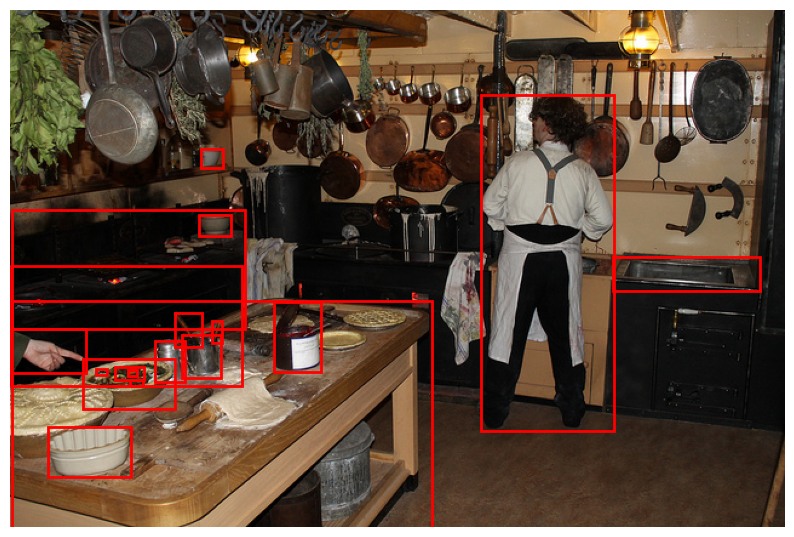

In [20]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path

cwd = Path.cwd()
annotations_path = cwd / 'coco/annotations/annotations/instances_val2017.json'
images_path = cwd / 'coco/images/val2017'

# Load the COCO annotations file
with open(annotations_path) as f:
    annotations_data = json.load(f)

# We'll take the first image ID in the annotations file.
first_image_info = annotations_data['images'][0]
image_file_name = first_image_info['file_name']
image_id = first_image_info['id']

# Define the image path using pathlib
image_path = images_path / image_file_name

# Load and display the image
image = Image.open(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Retrieve annotations for the selected image ID
image_annotations = [ann for ann in annotations_data['annotations'] if ann['image_id'] == image_id]

# Plot each bounding box from the annotations
for ann in image_annotations:
    # Get the bounding box coordinates
    x, y, w, h = ann['bbox']
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

# Display the image with bounding boxes
plt.axis('off')  # Optional: hide the axes
plt.show()


### Output Calculation

Each boundary box contains 5 elements: $(x, y, w, h)$ and a `box confidence score`. The confidence score reflects how likely the box contains an object (`objectness`) and how accurate is the boundary box. We normalize the bounding box width $(w)$ and height $(h)$ by the image width and height. $(x)$ and $(y)$ are offsets to the corresponding cell. Hence, $(x)$, $(y)$, $(w)$ and $(h)$ are all between 0 and 1.

Each cell has 20 conditional class probabilities. The conditional class probability is the probability that the detected object belongs to a particular class (one probability per category for each cell).

So, YOLO’s prediction has a shape of $(S, S, B×5 + C) = (7, 7, 2×5 + 20) = (7, 7, 30)$.

This structure is key to YOLO's single-shot detection capability. By predicting bounding boxes and class probabilities simultaneously for each grid cell, YOLO can detect multiple objects across different classes in a single forward pass through the network. This approach contrasts with two-stage detectors that first propose regions and then classify them, resulting in greater efficiency and speed, which are critical for real-time applications.

![YOLO predictions](https://raw.githubusercontent.com/arkeodev/demistify_deep_learning_applications/main/images/yolo_predictions.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Data Augmentation

Given the varying sizes of images and their objects, the dataset class also handles the normalization of bounding box coordinates relative to the image dimensions. Additionally, it applies any specified transformations to both the images and their bounding boxes, ensuring that the model receives input data in a consistent and optimized format.

Techniques like random cropping, flipping, and color jittering are applied to increase the diversity of the training data, which helps in improving the model's robustness.

Albumentations is a fast and flexible image augmentation library that provides a wide array of efficient and diverse augmentation techniques. This library is specifically designed to meet the needs of deep learning tasks in computer vision, offering support for augmentation of images, masks, bounding boxes, and keypoints.

The bbox_params argument specifies how bounding boxes should be treated during augmentations. It ensures that transformations like cropping or scaling are consistently applied to both the image and its associated bounding boxes.

In [34]:
image_size = 224

train_transform = A.Compose([A.SmallestMaxSize(max_size=image_size),
                             A.RandomCrop(height=image_size, width=image_size),
                             A.HorizontalFlip(p=0.5),
                             # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                             # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                             # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                             A.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                            ToTensorV2()],
                            bbox_params=A.BboxParams(format='coco',
                                                     min_area=0, min_visibility=0.0,
                                                     label_fields=['class_labels']))

inference_transform = A.Compose([A.SmallestMaxSize(max_size=image_size),
                       A.RandomCrop(height=image_size, width=image_size),
                       A.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
                       ToTensorV2()],
                       bbox_params=A.BboxParams(format='coco',
                                               min_area=0, min_visibility=0.0,
                                               label_fields=['class_labels']))

### Dataset Preparation

Custom dataset classes in PyTorch offer unparalleled flexibility and utility for handling complex datasets such as COCO dataset. They allow for precise control over the preprocessing and loading of data, enabling the development of more efficient, accurate, and robust object detection models. Through the detailed configuration of your CustomCocoDetection class, you showcase the power of custom dataset classes in navigating the challenges presented by the COCO dataset and tailoring the data preparation process to meet the specific needs of the YOLO algorithm.

In [35]:

class CustomCocoDetection(CocoDetection):
    def __init__(self, root, annFile, transform=None, grid_size=7, num_classes=20, num_boxes=2, image_size=416):
        super(CustomCocoDetection, self).__init__(root, annFile)
        self.transform = transform
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        self.image_size = image_size
        # Define your class ID mapping here:
        self.coco_to_voc = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19}

    def __getitem__(self, index):
        img, targets = super(CustomCocoDetection, self).__getitem__(index)
        new_targets = [obj for obj in targets if obj['category_id'] in self.coco_to_voc]

        # If no targets after filtering, fetch the next item
        if not new_targets:
            return self.__getitem__((index + 1) % len(self))

        boxes = [obj['bbox'] for obj in new_targets]

        # Remap class IDs
        category_ids = [self.coco_to_voc[obj['category_id']] for obj in new_targets]

        # Convert the PIL image to a numpy array
        img = np.array(img)

        if self.transform:
            # Apply the transformations
            transformed = self.transform(image=img, bboxes=boxes, class_labels=category_ids)

            img = transformed['image']
            boxes = transformed['bboxes']
            category_ids = transformed['class_labels']

            # Validate and filter out any bounding boxes that became invalid after transformation
            valid_boxes = []
            valid_category_ids = []
            for box, category_id in zip(boxes, category_ids):
                if box[2] > box[0] and box[3] > box[1]:  # Ensure x_max > x_min and y_max > y_min
                    valid_boxes.append(box)
                    valid_category_ids.append(category_id)

            # Update boxes and category_ids with only valid entries
            boxes = valid_boxes
            category_ids = valid_category_ids

        # Encode targets, adjusting for possibly empty boxes after filtering
        encoded_targets = self.encode_targets(boxes, category_ids) if boxes else torch.zeros((self.grid_size, self.grid_size, 5 * self.num_boxes + self.num_classes), dtype=torch.float32)

        return img, encoded_targets

    def encode_targets(self, boxes, category_ids):
        encoded_targets = torch.zeros((self.grid_size, self.grid_size, 5 * self.num_boxes + self.num_classes), dtype=torch.float32)
        for box, class_id in zip(boxes, category_ids):
            box_center_x = (box[0] + box[2] / 2) / self.image_size
            box_center_y = (box[1] + box[3] / 2) / self.image_size
            box_width = box[2] / self.image_size
            box_height = box[3] / self.image_size

            grid_x = int(box_center_x * self.grid_size)
            grid_y = int(box_center_y * self.grid_size)

            if encoded_targets[grid_y, grid_x, 4] == 0:  # Assuming one object per grid cell
                encoded_targets[grid_y, grid_x, :4] = torch.tensor([box_center_x, box_center_y, box_width, box_height], dtype=torch.float32)
                encoded_targets[grid_y, grid_x, 4] = 1  # Object presence
                encoded_targets[grid_y, grid_x, 5 + class_id] = 1  # Class probability

        return encoded_targets


In [36]:
train_data = CustomCocoDetection(
    root='./coco/images/train2017',
    annFile='./coco/annotations/annotations/instances_train2017.json',
    transform=train_transform,
    grid_size=7,
    num_classes=20,
    num_boxes=2,
    image_size=224
)

val_data = CustomCocoDetection(
    root='./coco/images/val2017',
    annFile='./coco/annotations/annotations/instances_val2017.json',
    transform=inference_transform,
    grid_size=7,
    num_classes=20,
    num_boxes=2,
    image_size=224
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

loading annotations into memory...
Done (t=26.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


## YOLO Loss Function

Implementing the YOLO loss function is a critical step in training the YOLO object detection model. The loss function is designed to optimize several aspects of the predictions, including the size and location of bounding boxes, the confidence score of those boxes, and the class predictions.

The YOLO loss function is composed of several parts: localization loss, confidence loss (objectness), and classification loss. These components are designed to ensure that the model accurately predicts bounding boxes, detects the presence of objects, and classifies those objects correctly.

It is also important to understnd Intersection ove Union concept, which quantizes the prediction of bounding boxes to real object's boxes ratio.



### 1. Localization Loss

Localization loss measures the error in the predicted bounding box location and size compared to the ground truth. YOLO parameterizes bounding boxes using the center coordinates $((x,y)$), width $(w$), and height $(h$). The loss is calculated only for the box responsible for detecting the object.

Mathematically, it is represented as:

$$
L_{\text{loc}} = \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (w_i - \hat{w}_i)^2 + (h_i - \hat{h}_i)^2 \right]
$$

where $( 1_{ij}^{\text{obj}} $) indicates if object appears in cell $( i )$ and bounding box $( j )$ is responsible for that prediction. $( \lambda_{\text{coord}} )$ increases the weight of this loss compared to other components.


This line computes the localization loss by comparing the predicted bounding boxes (`box_predictions`) with the ground truth (`box_targets`). It uses mean squared error (MSE) as the loss function, scaled by `lambda_coord` to adjust its contribution to the total loss.
 &nbsp;

```python
# Localization Loss
box_loss = self.lambda_coord * F.mse_loss(box_predictions, box_targets, reduction="sum")

```


### 2. Confidence Loss

Confidence loss measures the error in the confidence score of the bounding box. The confidence score reflects the model's certainty that a box contains an object and how accurate it thinks the box is.

It consists of two parts: loss for boxes with objects $( 1_{ij}^{\text{obj}} )$ and loss for boxes without objects $( 1_{ij}^{\text{noobj}} )$:

$$
L_{\text{conf}} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} (C_i - \hat{C}_i)^2 + \lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{noobj}} (C_i - \hat{C}_i)^2
$$

where $( C_i )$ is the confidence score.

```python
# Object Loss
obj_loss = F.mse_loss(exists_box * predictions[..., self.num_classes], exists_box * target[..., self.num_classes], reduction="sum")

# No-object Loss
no_obj_loss = self.lambda_noobj * F.mse_loss((1 - exists_box) * predictions[..., self.num_classes], (1 - exists_box) * target[..., self.num_classes], reduction="sum")
```
 &nbsp;

`obj_loss` calculates the error for boxes that are supposed to contain objects, while `no_obj_loss` does the same for boxes that do not contain objects, scaled by `lambda_noobj`. Most boxes do not contain any objects. This causes a class imbalance problem, i.e. we train the model to detect background more frequently than detecting objects. To remedy this, we weight this loss down by a factor `lambda_noobj` (default: 0.5).

### 3. Classification Loss

Classification loss measures the error in the predicted class probabilities compared to the ground truth. This component is active only for the cell containing the object.

$$
L_{\text{class}} = \sum_{i=0}^{S^2} 1_{i}^{\text{obj}} \sum_{c \in \text{classes}} (p_i(c) - \hat{p}_i(c))^2
$$

where $( p_i(c) )$ is the predicted probability for class $( c )$ in cell $( i )$.
 &nbsp;

```python
# Classification Loss
class_loss = F.mse_loss(exists_box * predictions[..., :self.num_classes], exists_box * target[..., :self.num_classes], reduction="sum")
```
 &nbsp;

This line computes the classification loss by comparing the predicted class probabilities `(predictions[..., :self.num_classes])` with the ground truth `(target[..., :self.num_classes])`, only for the cells that contain an object.


### Loss

The final loss adds localization, confidence and classification losses together.

$$
L_{\text{total}} = \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right] + \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} \left[ \left(w_i - \hat{w_i} \right)^2 + \left(h_i - \hat{h_i} \right)^2 \right] + \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} \left( C_i - \hat{C}_i \right)^2 + \lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{noobj}} \left( C_i - \hat{C}_i \right)^2 + \sum_{i=0}^{S^2} 1_{i}^{\text{obj}} \sum_{c \in \text{classes}} \left( p_i(c) - \hat{p}_i(c) \right)^2
$$

This equation combines the different components of the YOLO loss function: localization loss (first two terms), confidence loss for objects and no-objects (third and fourth terms), and classification loss (fifth term).

Each part is weighted accordingly to reflect its importance in the overall performance of the model.


### Intersection Over Union (IoU)

IoU is a fundamental metric in object detection used to quantify the accuracy of a predicted bounding box against the ground truth. It is defined as the ratio of the area of overlap between the predicted bounding box and the ground truth box to the area of their union.

#### IoU Calculation:

$$
\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$



#### Importance of IoU:

**Performance Evaluation:** IoU provides a clear and straightforward measure to evaluate and compare the performance of object detection models.

**Training Optimization:** By integrating IoU into the loss function, models can be trained more effectively to predict accurate bounding boxes.

#### Challenges and Solutions:

**Small Objects:** Detecting small objects can be difficult due to their limited presence in the image. Strategies like using higher resolution input images or focusing on specific layers of the network that retain fine-grained details can help.

**Class Imbalance:** Some classes might be overrepresented in the training data. Techniques such as focal loss or oversampling smaller classes can mitigate this issue.

In summary, the YOLO object detection system, with its innovative approach to bounding box prediction and class probability estimation, coupled with the critical metric of IoU, presents a powerful tool for real-time, accurate object detection across a wide range of applications. Understanding these concepts deeply not only aids in leveraging YOLO's full potential but also in navigating the challenges inherent in object detection tasks.

### Implementation

In [23]:
class YOLOLoss(nn.Module):
    def __init__(self, grid_size, num_boxes, num_classes, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()

        self.grid_size = grid_size  # grid size
        self.num_boxes = num_boxes  # number of bounding boxes
        self.num_classes = num_classes  # number of classes

        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, target):
        # Reshape predictions and target to (batch_size, S, S, C+B*5)
        predictions = predictions.reshape(-1, self.grid_size, self.grid_size, self.num_classes + self.num_boxes * 5)
        target = target.reshape(-1, self.grid_size, self.grid_size, self.num_classes + self.num_boxes * 5)

        # Calculate IoU for the two predicted bounding boxes with target
        iou_b1 = self.compute_iou(predictions[..., self.num_classes+1:self.num_classes+5], target[..., self.num_classes+1:self.num_classes+5])
        iou_b2 = self.compute_iou(predictions[..., self.num_classes+6:self.num_classes+10], target[..., self.num_classes+1:self.num_classes+5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        best_iou, best_box = ious.max(0)

        # 1 for the responsible box, 0 otherwise
        exists_box = target[..., self.num_classes].unsqueeze(3)  # Identity obj_i

        # Expand best_box for broadcasting
        best_box_expanded = best_box.unsqueeze(-1)  # Now best_box has shape [32, 7, 7, 1]

        # Squeeze the exists_box for shape matching
        exists_box_squeezed = exists_box.squeeze(-1)

        # Calculate Localization Loss
        box_predictions = exists_box * (
            (
                best_box_expanded * predictions[..., self.num_classes+6:self.num_classes+10]
                + (1 - best_box_expanded) * predictions[..., self.num_classes+1:self.num_classes+5]
            )
        )
        box_targets = exists_box * target[..., self.num_classes+1:self.num_classes+5]
        box_loss = self.lambda_coord * F.mse_loss(box_predictions, box_targets, reduction="sum")

        # Calculate Confidence Loss
        obj_loss = F.mse_loss(exists_box_squeezed * predictions[..., self.num_classes], exists_box_squeezed * target[..., self.num_classes], reduction="sum")
        no_obj_loss = self.lambda_noobj * F.mse_loss((1 - exists_box_squeezed) * predictions[..., self.num_classes], (1 - exists_box_squeezed) * target[..., self.num_classes], reduction="sum")

        # Calculate Classification Loss
        class_loss = F.mse_loss(exists_box * predictions[..., :self.num_classes], exists_box * target[..., :self.num_classes], reduction="sum")

        # Calculate Total Loss
        total_loss = box_loss + obj_loss + no_obj_loss + class_loss

        return total_loss

    @staticmethod
    def compute_iou(box1, box2):
      """
      Computes the IoU between two sets of boxes.
      box1, box2: (batch_size, grid_size, grid_size, 4) representing (x, y, w, h) for each box.
      """
      # Convert boxes from (x, y, w, h) to (x1, y1, x2, y2)
      box1_x1 = box1[..., 0] - box1[..., 2] / 2
      box1_y1 = box1[..., 1] - box1[..., 3] / 2
      box1_x2 = box1[..., 0] + box1[..., 2] / 2
      box1_y2 = box1[..., 1] + box1[..., 3] / 2

      box2_x1 = box2[..., 0] - box2[..., 2] / 2
      box2_y1 = box2[..., 1] - box2[..., 3] / 2
      box2_x2 = box2[..., 0] + box2[..., 2] / 2
      box2_y2 = box2[..., 1] + box2[..., 3] / 2

      # Intersection area
      inter_area = (torch.min(box1_x2, box2_x2) - torch.max(box1_x1, box2_x1)).clamp(min=0) * \
                  (torch.min(box1_y2, box2_y2) - torch.max(box1_y1, box2_y1)).clamp(min=0)

      # Union Area
      box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
      box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
      union_area = box1_area + box2_area - inter_area

      # IoU
      iou = inter_area / union_area.clamp(min=1e-6)

      return iou

This implementation introduces several hyperparameters, such as ***lambda_coord*** and ***lambda_noobj***, which are used to balance the different components of the loss function. Adjusting these parameters can have a significant impact on the model's performance, particularly in terms of balancing the trade-off between localization accuracy and confidence in predictions.

By breaking down the YOLO loss into its constituent parts and carefully implementing the calculations, this loss function enables effective training of YOLO models on a variety of datasets.

## Model Architecture

We employ a pretrained network for feature extraction, utilizing transfer learning to improve efficiency and accuracy. Specifically, we modify ResNet34, pretrained on ImageNet, to suit our object detection task. The model's final layer is adapted to predict bounding boxes and class probabilities.

The YOLO object detection model consists of two primary components:

**Feature Extractor:** Utilizes a pretrained ResNet-34 model, with its final layer removed, to extract meaningful features from input images. ResNet-34 is chosen for its balance between accuracy and computational efficiency, making it suitable for a wide range of object detection tasks. The feature extractor processes input images to produce a set of feature maps that encode spatial hierarchies of features learned from vast amounts of visual data.

**Detection Layer:** A custom sequence of layers designed to interpret the feature maps and output object detection predictions. This component includes a flattening layer to transform the feature maps into a vector, followed by fully connected layers and nonlinear activations to predict the properties of bounding boxes (location, size) and the probabilities of object classes within each grid cell of the image.

In [24]:
class YOLOObjectDetector(nn.Module):
    """
    YOLO Object Detection model leveraging a pretrained backbone for feature extraction.

    Attributes:
        feature_extractor (nn.Sequential): Feature extraction model.
        detection_layer (nn.Sequential): Custom layer to output detection predictions.
        image_size (int): The size of the input images (square images).
        grid_size (int): The dimension of the output grid (S x S).
        num_boxes (int): Number of bounding boxes (B) to predict per grid cell.
        num_classes (int): Number of object classes (C).
    """
    def __init__(self, backbone, image_size, grid_size, num_boxes, num_classes):
        """
        Initializes the YOLO object detection model with a given backbone.

        Parameters:
            backbone (nn.Module): Pretrained CNN model to use as the feature extraction backbone.
            image_size (int): Size of the input images. Assumes square images.
            grid_size (int): The dimension of the grid size into which the image is divided.
            num_boxes (int): Number of bounding boxes to predict for each grid cell.
            num_classes (int): Number of object classes for classification.
        """
        super(YOLOObjectDetector, self).__init__()
        self.image_size = image_size
        self.grid_size = grid_size
        self.num_boxes = num_boxes
        self.num_classes = num_classes

        # Modify the backbone by removing the final layer
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])

        # Calculate the size of the flattened features after the feature extractor
        dummy_input = torch.autograd.Variable(torch.rand(1, 3, image_size, image_size))
        features_size = self.feature_extractor(dummy_input).data.view(1, -1).size(1)

        # Define the final layer to output the detection predictions
        self.detection_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(features_size, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, grid_size * grid_size * (num_classes + num_boxes * 5)),
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters:
            x (torch.Tensor): Input tensor of images.

        Returns:
            torch.Tensor: The model's predictions for each image.
        """
        features = self.feature_extractor(x)
        predictions = self.detection_layer(features)
        output_shape = (-1, self.grid_size, self.grid_size, (self.num_classes + self.num_boxes * 5))
        return predictions.reshape(output_shape)

## Training

In [27]:
from torch.optim import Adam

# Parameters
image_size = 224  # Example image size, adjust as needed
grid_size = 7     # Common choice for YOLO
num_boxes = 2     # Typically 2 or 3
num_classes = 20  # Adjust based on your dataset

# Initialize the backbone
backbone = models.resnet34(pretrained=True)

# Create our network
yolo_model = YOLOObjectDetector(backbone=backbone,
                                image_size=image_size,
                                grid_size=grid_size,
                                num_boxes=num_boxes,
                                num_classes=num_classes).to(device)

# Learning rate
learning_rate = 1e-4

# Setup optimizer
optimizer = Adam(yolo_model.parameters(), lr=learning_rate)

# YOLO Loss
loss_function = YOLOLoss(grid_size=grid_size, num_boxes=num_boxes, num_classes=num_classes).to(device)

# Number of epochs
num_epochs = 2

# Evaluation metric is IOU
eval_metric = loss_function.compute_iou

# Placeholder for logging
loss_log = []
train_iou_log = []
val_iou_log = []

In [28]:
def compute_iou_metric(predictions, targets):
    """
    Calculates the mean IoU (Intersection over Union) between predicted and
    target bounding boxes.

    predictions and targets tensors should have the shape (batch_size, grid_size,
    grid_size, num_classes + num_boxes * 5) where the bounding box predictions
    are expected in the format (x, y, w, h) after the class probabilities.

    Args:
    predictions (torch.Tensor): The predicted tensor from the YOLO model.
    targets (torch.Tensor): The ground truth tensor.

    Returns:
    float: Mean IoU for the batch.
    """
    num_boxes = 2  # Assuming 2 bounding boxes per cell, adjust based on your model
    grid_size = predictions.shape[1]  # Assuming square grid
    num_classes = 20  # Adjust based on your setup

    # Reshape if your predictions and targets are not already in the expected shape
    predictions = predictions.reshape(-1, grid_size, grid_size, num_classes + num_boxes * 5)
    targets = targets.reshape(-1, grid_size, grid_size, num_classes + num_boxes * 5)

    iou_scores = []

    for i in range(num_boxes):
        pred_start_index = num_classes + i * 5 + 1
        pred_boxes = predictions[..., pred_start_index:pred_start_index + 4]
        target_boxes = targets[..., num_classes + 1:num_classes + 5]  # Assuming target boxes are the same for both predictions

        ious = YOLOLoss.compute_iou(pred_boxes, target_boxes)  # Static method call
        iou_scores.append(ious)

    # Take the max IoU across the two predicted boxes for each cell
    max_ious, _ = torch.cat(iou_scores, dim=0).max(0)

    # Compute mean IoU across all cells and all batches
    mean_iou = max_ious.mean()

    return mean_iou.item()


In [29]:
def evaluate_model(loader, description="Evaluation"):
    total_loss = 0
    total_iou = 0
    count = 0
    images_processed = 1
    yolo_model.eval()
    with torch.no_grad():
        for images, targets in tqdm(loader, desc=description, leave=False):
            if images_processed % 300 == 0:
              print(f"Loss: {total_loss:.4f}, IoU: {total_iou:.4f}")

            images, targets = images.to(device), targets.to(device)
            predictions = yolo_model(images)
            loss = loss_function(predictions, targets)
            iou = compute_iou_metric(predictions, targets)  # Placeholder for actual IoU computation
            total_loss += loss.item()
            total_iou += iou
            count += 1
            images_processed += 1
    return total_loss / count, total_iou / count

In [30]:
def train_step(model, loader, device, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_function(predictions, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

In [31]:
def save_checkpoint(model, val_loss, best_val_loss, epoch, path='best_model_yolo.pth'):
    if val_loss < best_val_loss:
        print(f"Epoch {epoch+1}: New best model saved with val_loss: {val_loss:.4f}")
        torch.save(model.state_dict(), path)
        return val_loss
    return best_val_loss

In [32]:
def log_metrics(writer, epoch, train_loss, val_loss, train_iou, val_iou):
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('IoU/train', train_iou, epoch)
    writer.add_scalar('IoU/val', val_iou, epoch)

In [ ]:
def train_model(model, train_loader, val_loader, device, optimizer, loss_fn, num_epochs, writer_path='runs/yolo_experiment_1'):
    writer = SummaryWriter(writer_path)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train_step(model, train_loader, device, optimizer, loss_fn)
        train_loss /= len(train_loader.dataset)

        train_loss, train_iou = evaluate_model(train_loader, "Training Evaluation")
        val_loss, val_iou = evaluate_model(val_loader, "Validation Evaluation")

        log_metrics(writer, epoch, train_loss, val_loss, train_iou, val_iou)
        best_val_loss = save_checkpoint(model, val_loss, best_val_loss, epoch)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

    writer.close()

# Example usage
train_model(yolo_model, train_loader, val_loader, device, optimizer, loss_function, num_epochs)



In [ ]:
! tensorboard --logdir=runs

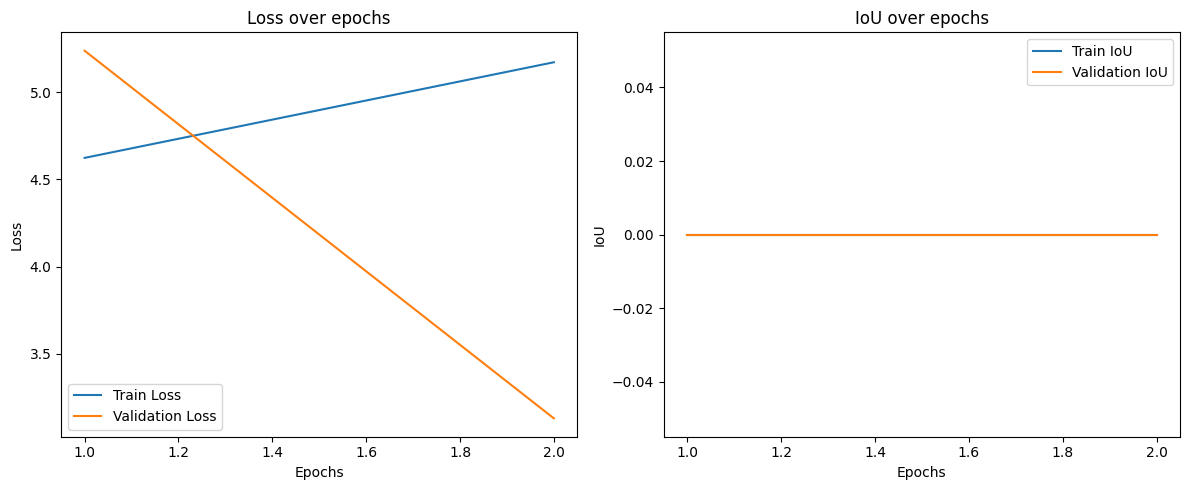

In [76]:
# Plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, [x[0] for x in loss_log], label='Train Loss')
plt.plot(epochs, [x[1] for x in loss_log], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_iou_log, label='Train IoU')
plt.plot(epochs, val_iou_log, label='Validation IoU')
plt.title('IoU over epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()



1. Finish the inference
3. IoU returns 0




